In [1]:
novel_path = dict()
novel_path["광염소나타"] = '김동인-광염_소나타-중외일보.txt'
novel_path["매밀꽃필무렵"] = '매밀꽃필무렵.txt'
novel_path["창세기40장"] = '창세기40장.txt'
novel_path["어린왕자"] = '어린왕자.txt'



In [2]:
model_pos_dir = 'model_pos.pt'
model_exc_dir = 'model_exc.pt'
model_ang_dir = 'model_ang.pt'

result_dir = 'result.txt'
result_str = ""

In [3]:
!pip install transformers
!pip install pandas
!pip install konlpy

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from konlpy.tag import Okt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import tensorflow as tf
from transformers import BertTokenizerFast, BertModel, get_cosine_schedule_with_warmup
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
import os
import sys
import numpy as np
import re
import pickle
import time
import pandas as pd
from pathlib import Path
import random
import math


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

2023-06-22 20:38:41.600847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 20:38:42.628304: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.cuda.get_arch_list())
print(torch.zeros(1).cuda())

os.environ["CUDA_VISIBLE_DEVICES"]="1"

True
2.0.0
['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'compute_37']
tensor([0.], device='cuda:0')


In [6]:
data_file_binary = '/mnt/nas2/seogyeong/23spring/arranged_emotion_text_binary_shuffled.csv'
df = pd.read_csv(data_file_binary, encoding='UTF8', header=None, dtype={'a': str, 'b':int, 'c':int}).to_numpy()

df = np.array([df.T[0], df.T[1], df.T[2]]).T
print(df)

np.random.shuffle(df)
df = df.T
print(df)


[['배신감에 찬 그녀는 지금껏 그에게서 받은 편지를 모두 찢어발겨 없앴다. ' 0 1]
 ['방문을 열자 방 안에 죽음의 검은 그림자들처럼 참담하게 앉아 있던 여러 사람들의 눈길이 한꺼번에 그에게로 쏠려 왔다. ' 0
  0]
 ['한이\xa0서리다.' 1 0]
 ...
 ['여보게, 창피한 말이지만 나는 오늘 조반도 아직 못 먹었네. ' 0 1]
 ['그녀는 예상하지 못했던 기자들의 질문에 당황하여 잠시 대답을 망설였다. ' 0 0]
 ['뱅골댁은\xa0어떤\xa0배신감\xa0같은\xa0것을\xa0느끼며\xa0한바탕\xa0대거리를\xa0벌일\xa0것처럼\xa0소리를\xa0질러\xa0댔다.'
  1 0]]
[['그 드라마에서는 앞으로 주인공이 악인을 물리치고 승승장구하는 모습이 통쾌하게 그려질 예정이다.'
  '그들의 죽은 듯한 은신은, 겨우 반나절이 못되어 허무하게 발각되었다.'
  '그런대로 어둠을 머금고 멀리 물러앉은 산봉우리마다 활활 타는 저녁놀은 너무나 황홀하였다. ' ...
  '그는 들어오라는 주인의 말에 잠깐 망설이다가 안으로 들어섰다. ' '방이 따뜻하여서 기분이 좋다. '
  '양파의 맛이 얼근덜근해서 참 좋다. ']
 [1 0 1 ... 0 1 1]
 [1 0 1 ... 0 1 1]]


In [7]:

X = df[0]
Y_pos = df[1]
Y_exc = df[2]

train_n = int(len(X)*0.8)
test_n = len(X) - train_n
print("train_n: ", train_n)
print("test_n: ", test_n)


X_train = X[:train_n]
X_test = X[train_n:]

Y_train_p = Y_pos[:train_n]
Y_test_p = Y_pos[train_n:]
Y_train_e = Y_exc[:train_n]
Y_test_e = Y_exc[train_n:]

train_n:  1613
test_n:  404


In [8]:
learning_rate =  5e-5
num_epochs = 5
batch_size = 32
warmup_ratio = 0.1

In [9]:
def set_random(SEED=0):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

In [10]:
# load pretrained model
def get_model():
    # * Model          | Tokenizer          | Pretrained weights shortcut
    # MODEL=(DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')
    tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
    model = BertModel.from_pretrained("kykim/bert-kor-base")
    n_hl = model.config.num_hidden_layers
    embed_dim = model.config.embedding_size
    return model, tokenizer, n_hl, embed_dim

In [11]:
model, tokenizer, n_hl, embed_dim = get_model()
# tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
train_text_tensor = tokenizer(X_train.tolist(), max_length=model.config.max_position_embeddings, return_tensors='pt', padding=True)
test_text_tensor = tokenizer(X_test.tolist(), max_length=model.config.max_position_embeddings, return_tensors='pt', padding=True)


/root/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [13]:
class MyMapDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data['input_ids'])

    def __getitem__(self, idx):
        data = {k:v[idx] for k,v in self.data.items()}
        return data

In [14]:
def forward(model, dl, device=0):
    pooled = []
    hidden = []
    model.cuda(device)
    model.eval()
    for data in dl:
        data = {k:v.cuda(device) for k,v in data.items()}
        with torch.no_grad():
            output = model(**data, output_hidden_states=True)
        p, h = output.pooler_output, output.hidden_states
        pooled.append(p) # pooler output
        hidden.append(h[-1][:,0,:]) # only [CLS] token embedding 
    return torch.cat(pooled), torch.cat(hidden)

In [15]:

train_result = train_text_tensor['input_ids']
test_result = test_text_tensor['input_ids']

train_attmask = train_text_tensor['attention_mask']
test_attmask = test_text_tensor['attention_mask']


In [16]:
class MyDataset(Dataset):
    def __init__(self, data, data_attmask, label_pos, label_exc):
        self.data = data
        self.data_attmask = data_attmask
        self.label_pos = label_pos
        self.label_exc = label_exc

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data_attmask[idx], torch.tensor(self.label_pos[idx]), torch.tensor(self.label_exc[idx])
  

In [17]:
def train(model, dl, optimizer, scheduler, criterion, train_mode, device=1):
    model = model.cuda(device)
    model.train()
    loss_all, acc_all = 0, 0
    
    batch = 0
    for data, att_mask, label_pos, label_exc in dl:
        batch += 1

        data, att_mask, label_pos, label_exc = data.cuda(device), att_mask.cuda(device), label_pos.cuda(device), label_exc.cuda(device)
        if train_mode == 0:
            label = label_pos
            label_name = "pos/neg"
        else:
            label = label_exc
            label_name = "exc/aro"

        output = model(data, att_mask, len(data[0]))
        

        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        acc = (output.argmax(axis=1) == label).sum() / len(label)

        loss_all += loss.item()
        acc_all += acc.item()


        if batch % 20 == 0:

            print(f"  [{label_name} batch {batch}] acc: {acc.item()}, loss: {loss.item()}")
        del data, att_mask, label_pos, label_exc
        torch.cuda.empty_cache()


    loss = loss_all / len(dl)
    acc = acc_all / len(dl)

    return loss, acc


In [18]:
def valid(model_pos, model_exc, dl, criterion, device=1):
    model_pos = model_pos.cuda(device)
    model_pos.eval()

    model_exc = model_exc.cuda(device)
    model_exc.eval()

    loss_all_pos, acc_all_pos = 0, 0
    loss_all_exc, acc_all_exc = 0, 0
    acc_all = 0
    
    # output_list = []
    batch = 0
    for data, att_mask, label_pos, label_exc in dl:
        batch +=1
        data, att_mask, label_pos, label_exc = data.cuda(device), att_mask.cuda(device), label_pos.cuda(device), label_exc.cuda(device)

        #Pos/Neg
        output_pos = model_pos(data, att_mask, len(data[0]))
        loss_pos = criterion(output_pos, label_pos)
        acc_pos = (output_pos.argmax(axis=1) == label_pos).sum() / len(label_pos)
        loss_all_pos += loss_pos.item()
        acc_all_pos += acc_pos.item()

        #Exc/Aro
        output_exc = model_exc(data, att_mask, len(data[0]))
        loss_exc = criterion(output_exc, label_exc)
        acc_exc = (output_exc.argmax(axis=1) == label_exc).sum() / len(label_exc)
        loss_all_exc += loss_exc.item()
        acc_all_exc += acc_exc.item()
        # output_list.append(output.argmax(dim=1).cpu())

        # Total
        total_acc = ((((output_pos.argmax(axis=1) == label_pos).int())+((output_exc.argmax(axis=1) == label_exc).int()))==2).sum() / len(label_pos)

        acc_all += total_acc.item()
        
        del data, att_mask, label_pos, label_exc
        torch.cuda.empty_cache()
        
    loss_pos = loss_all_pos / len(dl)
    acc_pos = acc_all_pos / len(dl)

    loss_exc = loss_all_exc / len(dl)
    acc_exc = acc_all_exc / len(dl)

    acc = acc_all / len(dl)


    return loss_pos, acc_pos, loss_exc, acc_exc,  acc

In [19]:
class BERTClassifier_binary(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes= 2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier_binary, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.linear = nn.Linear(hidden_size , num_classes)
        self.classifier = nn.Softmax(dim=1)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, token_ids, attention_mask, valid_length):
        pooler = self.bert(input_ids = token_ids, token_type_ids = None, attention_mask = attention_mask).pooler_output
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        out = self.linear(out)
        return self.classifier(out)

In [20]:
model_bert_pos = BertModel.from_pretrained("kykim/bert-kor-base")
model_bert_exc = BertModel.from_pretrained("kykim/bert-kor-base")

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.

In [21]:
model_pos = BERTClassifier_binary(model_bert_pos, dr_rate = 0.4).cuda(0)
model_exc = BERTClassifier_binary(model_bert_exc, dr_rate = 0.4).cuda(0)


In [22]:
train_ds = MyDataset(train_result, train_attmask, Y_train_p, Y_train_e)
test_ds = MyDataset(test_result, test_attmask, Y_test_p, Y_test_e)

# batch size 1024 -> 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [23]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters_pos = [
    {'params': [p for n, p in model_pos.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model_pos.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer_grouped_parameters_exc = [
    {'params': [p for n, p in model_exc.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model_exc.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer_pos = AdamW(optimizer_grouped_parameters_pos, lr=learning_rate)
optimizer_exc = AdamW(optimizer_grouped_parameters_exc, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dl) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler_pos = get_cosine_schedule_with_warmup(optimizer_pos, num_warmup_steps=warmup_step, num_training_steps=t_total)
scheduler_exc = get_cosine_schedule_with_warmup(optimizer_exc, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [24]:
def main_binary(device=1):  
  
  # train

  for epoch in range(num_epochs):
    print()
    print()
    print("epoch: ", epoch+1)

    train_loss_pos, train_acc_pos = train(model_pos, train_dl, optimizer_pos, scheduler_pos, loss_fn, 0, device = device)
    train_loss_exc, train_acc_exc = train(model_exc, train_dl, optimizer_exc, scheduler_exc, loss_fn, 1, device = device)

    val_loss_pos, val_acc_pos, val_loss_exc, val_acc_exc, val_acc_all = valid(model_pos, model_exc, test_dl, loss_fn, device = device)

    print('Acc/Train(pos): ', train_acc_pos, 'Loss/Train(pos): ', train_loss_pos)
    print('Acc/Train(exc): ', train_acc_exc, 'Loss/Train(exc): ', train_loss_exc)
    print('Acc/Test(pos): ', val_acc_pos, 'Loss/Test(pos): ', val_loss_pos)
    print('Acc/Test(exc): ', val_acc_exc, 'Loss/Test(exc): ', val_loss_exc)
    print("Total Acc(pos & exc): ", val_acc_all)

In [25]:
# Train all
set_random(422)
main_binary(0)



epoch:  1
  [pos/neg batch 20] acc: 0.71875, loss: 0.6379625797271729
  [pos/neg batch 40] acc: 0.875, loss: 0.44287610054016113
  [exc/aro batch 20] acc: 0.40625, loss: 0.78700190782547
  [exc/aro batch 40] acc: 0.46875, loss: 0.732913076877594
Acc/Train(pos):  0.6927319017111087 Loss/Train(pos):  0.5832204357081768
Acc/Train(exc):  0.5896493214018205 Loss/Train(exc):  0.6804951078751508
Acc/Test(pos):  0.887500001833989 Loss/Test(pos):  0.42559547149218047
Acc/Test(exc):  0.5836538489048297 Loss/Test(exc):  0.6721533170113196
Total Acc(pos & exc):  0.5423076932246869


epoch:  2
  [pos/neg batch 20] acc: 0.96875, loss: 0.34975749254226685
  [pos/neg batch 40] acc: 0.84375, loss: 0.46872636675834656
  [exc/aro batch 20] acc: 0.59375, loss: 0.7010382413864136
  [exc/aro batch 40] acc: 0.71875, loss: 0.6399259567260742
Acc/Train(pos):  0.8890931372549019 Loss/Train(pos):  0.4235369820220798
Acc/Train(exc):  0.6547417056326773 Loss/Train(exc):  0.6404440157553729
Acc/Test(pos):  0.9201

In [26]:
torch.save(model_pos, model_pos_dir)
torch.save(model_exc, model_exc_dir)
del model_pos
del model_exc
torch.cuda.empty_cache()

In [27]:
data_file = '/mnt/nas2/seogyeong/23spring/arranged_emotion_text_angle_shuffled.csv'
train_ratio = 0.7
df = pd.read_csv(data_file, encoding='UTF8', header=None, dtype={'a': str, 'b':float}).to_numpy()[1:]

df = np.array([df.T[0], df.T[1]]).T

np.random.shuffle(df)
df = df.T

In [28]:

X = df[0]
Y = df[1]

train_n = int(len(X)*0.8)
test_n = len(X) - train_n
print("train_n: ", train_n)
print("test_n: ", test_n)


X_train = X[:train_n]
X_test = X[train_n:]

Y_train = Y[:train_n].astype(float)
Y_test = Y[train_n:].astype(float)

train_n:  1613
test_n:  404


In [29]:
learning_rate =  5e-5
num_epochs = 20
batch_size = 32
warmup_ratio = 0.1

In [30]:
train_text_tensor = tokenizer(X_train.tolist(), max_length=model.config.max_position_embeddings, return_tensors='pt', padding=True)
test_text_tensor = tokenizer(X_test.tolist(), max_length=model.config.max_position_embeddings, return_tensors='pt', padding=True)

/root/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [31]:
class MyMapDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data['input_ids'])

    def __getitem__(self, idx):
        data = {k:v[idx] for k,v in self.data.items()}
        return data

In [32]:
def forward(model, dl, device=0):
    pooled = []
    hidden = []
    model.cuda(device)
    model.eval()
    for data in dl:
        data = {k:v.cuda(device) for k,v in data.items()}
        with torch.no_grad():
            output = model(**data, output_hidden_states=True)
        p, h = output.pooler_output, output.hidden_states
        pooled.append(p) # pooler output
        hidden.append(h[-1][:,0,:]) # only [CLS] token embedding 
    return torch.cat(pooled), torch.cat(hidden)

In [33]:

train_result = train_text_tensor['input_ids']
test_result = test_text_tensor['input_ids']

train_attmask = train_text_tensor['attention_mask']
test_attmask = test_text_tensor['attention_mask']


In [34]:
class MyDataset(Dataset):
    def __init__(self, data, data_attmask, label):
        self.data = data
        self.data_attmask = data_attmask
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx].float(), self.data_attmask[idx].float(), torch.tensor(self.label[idx])
  

In [35]:
def train(model, dl, optimizer, scheduler, criterion, device=1):
    model = model.cuda(device)
    model.train()
    loss_all = 0
    
    batch = 0
    for data, att_mask, label in dl:
        batch += 1

        data, att_mask, label = data.cuda(device), att_mask.cuda(device), label.cuda(device).float()

        output = model(data, att_mask, len(data[0]))
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        loss_all += loss.item()


        if batch % 20 == 0:

            print(f"  [ batch {batch}] loss: {loss.item()}")
        del data, att_mask, label 
        torch.cuda.empty_cache()

    loss = loss_all / len(dl)

    return loss


In [36]:
def valid(model, dl, criterion, device=1):
    model = model.cuda(device)
    model.eval()

    loss_all = 0
    
    # output_list = []
    batch = 0
    for data, att_mask, label in dl:
        batch +=1
        data, att_mask, label = data.cuda(device), att_mask.cuda(device), label.cuda(device)


        #Exc/Aro
        output = model(data, att_mask, len(data[0]))
        loss = criterion(output, label)
        loss_all += loss.item()
        # output_list.append(output.argmax(dim=1).cpu())
        del data, att_mask, label 
        torch.cuda.empty_cache()
    
    loss = loss_all / len(dl)
    

    return loss

In [37]:

def round_below(x):
    return torch.floor(x)


def custom_activation(x):
    a = round_below(torch.mul(x, 1.0/360))
    x = torch.add(x, torch.mul(a, -360.0))
    return(x)

def my_loss(output, target):
    output = torch.reshape(output, (-1,))
    new_torch1 = torch.abs(output - target)
    new_torch2 = torch.mul(new_torch1, -1)
    new_torch2 = torch.add(new_torch2, 360.0)
    
    temp = torch.mul(new_torch2, -1)
    abs_torch = torch.add(temp, new_torch1)
    abs_torch = torch.abs(abs_torch)
    abs_torch = torch.mul(abs_torch, -1)
    
    
    add_torch = torch.add(new_torch1, new_torch2)
    
    
    ans = torch.mul(torch.add(abs_torch, add_torch), 0.5)
    ans = torch.mean(ans**2)
    return ans



In [38]:
class BERTClassifier_angle(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes= 1,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier_angle, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier1 = nn.Linear(hidden_size , 384)
        self.relu1 = nn.ReLU()
        self.classifier2 = nn.Linear( 384, 1)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, token_ids, attention_mask, valid_length):
        pooler = self.bert(input_ids = token_ids.long(), token_type_ids = None, attention_mask = attention_mask).pooler_output
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        out = self.classifier1(out)
        out = self.relu1(out)
        out = self.classifier2(out)
        # return custom_activation(out)
        out = torch.tanh(out)  # Apply Tanh activation directly to the output tensor
        out = torch.mul(out, 180)
        out = torch.add(out, 180)
        return out

In [39]:
model_bert = BertModel.from_pretrained("kykim/bert-kor-base")

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
model = BERTClassifier_angle(model_bert, dr_rate = 0.4).cuda(0)

In [41]:
train_ds = MyDataset(train_result, train_attmask, Y_train)
test_ds = MyDataset(test_result, test_attmask, Y_test)


# batch size 1024 -> 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [42]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
# loss_fn = nn.MSELoss()
loss_fn = my_loss

t_total = len(train_dl) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [43]:
def main_ang(device=1):  
  
  # train

  for epoch in range(num_epochs):
    print()
    print()
    print("epoch: ", epoch+1)

    train_loss = train(model, train_dl, optimizer, scheduler, loss_fn, device = device)

    val_loss = valid(model, test_dl, loss_fn, device = device)

    print('Loss/Train: ', train_loss,   ', Loss/test: ', val_loss)

In [44]:
# Train all
set_random(422)
main_ang(0)



epoch:  1
  [ batch 20] loss: 10142.408203125
  [ batch 40] loss: 10211.396484375
Loss/Train:  9487.500718060663 , Loss/test:  7972.932055197336


epoch:  2
  [ batch 20] loss: 6323.658203125
  [ batch 40] loss: 2320.77587890625
Loss/Train:  6084.002841126685 , Loss/test:  3857.1703427684283


epoch:  3
  [ batch 20] loss: 3037.7939453125
  [ batch 40] loss: 2938.8544921875
Loss/Train:  3272.641939051011 , Loss/test:  1823.4465938266765


epoch:  4
  [ batch 20] loss: 1028.9727783203125
  [ batch 40] loss: 3986.89990234375
Loss/Train:  1626.6721221325445 , Loss/test:  976.0341799315848


epoch:  5
  [ batch 20] loss: 484.2004089355469
  [ batch 40] loss: 588.4794921875
Loss/Train:  1044.4665760713465 , Loss/test:  735.2649659552321


epoch:  6
  [ batch 20] loss: 412.95196533203125
  [ batch 40] loss: 666.0171508789062
Loss/Train:  916.5588103649663 , Loss/test:  792.971487989617


epoch:  7
  [ batch 20] loss: 688.4157104492188
  [ batch 40] loss: 711.3955078125
Loss/Train:  746.759

In [45]:
torch.save(model, model_ang_dir)
del model
torch.cuda.empty_cache()

In [46]:
model_pos = torch.load(model_pos_dir).cuda(0)
model_exc = torch.load(model_exc_dir).cuda(0)
model_ang = torch.load(model_ang_dir).cuda(0)
any_string1 = "나는 행복하다."
any_string2 = "나는 불행하다."
realtest_tensor1 = tokenizer([any_string1], max_length=len(any_string1), return_tensors='pt', padding=True)
realtest_result1 = realtest_tensor1['input_ids'].cuda(0)
realtest_attmask1 = realtest_tensor1['attention_mask'].cuda(0)
realtest_tensor2 = tokenizer([any_string2], max_length=len(any_string1), return_tensors='pt', padding=True)
realtest_result2 = realtest_tensor2['input_ids'].cuda(0)
realtest_attmask2 = realtest_tensor2['attention_mask'].cuda(0)

output1 = model_pos(realtest_result1, realtest_attmask1, len(realtest_result1[0]))
print(output1)
output2 = model_pos(realtest_result2, realtest_attmask2, len(realtest_result2[0]))
print(output2)

output1 = model_exc(realtest_result1, realtest_attmask1, len(realtest_result1[0]))
print(output1)
output2 = model_exc(realtest_result2, realtest_attmask2, len(realtest_result2[0]))
print(output2)

output1 = model_ang(realtest_result1, realtest_attmask1, len(realtest_result1[0]))
print(output1)
output2 = model_ang(realtest_result2, realtest_attmask2, len(realtest_result2[0]))
print(output2)

del model_pos, model_exc, model_ang, realtest_result1, realtest_attmask1, realtest_result2, realtest_attmask2
torch.cuda.empty_cache()

tensor([[2.2878e-04, 9.9977e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[9.9985e-01, 1.5082e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.0013, 0.9987]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.0011, 0.9989]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[21.0381]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[186.1409]], device='cuda:0', grad_fn=<AddBackward0>)


In [47]:
def get_data(path):
    delete_keys = ['', '"', "'", ]
    f = open(path, 'r')
    lines = []
    while True:
        line = f.readline()
        if not line: 
            break
        lines.append(line)
    f.close()
    sentences = []
    for line in lines:
        temp = line.replace('\n', '')
        if len(temp) == 0:
            continue
        sentences = sentences + temp.split('.')
    for delword in delete_keys:
        while delword in sentences:
            sentences.remove(delword)
    
    # IMPORTANT! Concatenate sentences
    new_sentences = list()
    temp_sent = ""
    count = 0
    for sent in sentences:
        count += 1
        if count % 5 == 0:
            new_sentences.append(temp_sent)
            temp_sent = ""
        temp_sent += sent + ". "
    if not count == 0:
        new_sentences.append(temp_sent)
    return new_sentences

In [48]:

import matplotlib

# matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False
import matplotlib.pyplot as plt
def draw_binary(pos_neg, exc_aro, title):
    assert(len(pos_neg) == len(exc_aro))
    circle = []
    for i in range(len(pos_neg)):
        x = pos_neg[i]
        y = exc_aro[i]

        if len(exc_aro) < 36:
            if i <= 12:
                color = [float(255 - 20 * i)/255.0, 0, 0]
            elif i <= 24:
                color = [0, float(255 - 20 * (i-12))/255.0, 0]
            else:
                color = [0, 0, float(255 - 20 * (i-24))/255.0]
        elif len(exc_aro) < 240:
            if i <= 80:
                color = [float(255 -  3*i)/255.0, 0, 0]
            elif i <= 160:
                color = [0, float(255 - 3*(i-80))/255.0, 0]
            else:
                color = [0, 0, float(255 - 3*(i-160))/255.0]
        elif len(exc_aro) < 750:
            if i <= 250:
                color = [float(255 -  i)/255.0, 0, 0]
            elif i <= 500:
                color = [0, float(255 - (i-250))/255.0, 0]
            else:
                color = [0, 0, float(255 - (i-500))/255.0]
        else:
            color = color = [1, 0, 0]
        circle1 = plt.Circle((x, y), 0.02, color=color)
        circle.append(circle1)
    fig, ax = plt.subplots()
    for c in circle:
        ax.add_patch(c)
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.title(title)
    plt.show()

In [49]:
def draw_angle(angle_list, title):
    circle = []
    for i in range(len(angle_list)):
        angle = angle_list[i]

        if len(angle_list) < 36:
            if i <= 12:
                color = [float(255 - 20 * i)/255.0, 0, 0]
            elif i <= 24:
                color = [0, float(255 - 20 * (i-12))/255.0, 0]
            else:
                color = [0, 0, float(255 - 20 * (i-24))/255.0]
        elif len(angle_list) < 240:
            if i <= 80:
                color = [float(255 -  3*i)/255.0, 0, 0]
            elif i <= 160:
                color = [0, float(255 - 3*(i-80))/255.0, 0]
            else:
                color = [0, 0, float(255 - 3*(i-160))/255.0]
        elif len(angle_list) < 750:
            if i <= 250:
                color = [float(255 -  i)/255.0, 0, 0]
            elif i <= 500:
                color = [0, float(255 - (i-250))/255.0, 0]
            else:
                color = [0, 0, float(255 - (i-500))/255.0]
        else:
            color = color = [1, 0, 0]
        circle1 = plt.Circle((math.cos(math.radians(angle)), math.sin(math.radians(angle))), 0.02, color=color)
        circle.append(circle1)
    fig, ax = plt.subplots()
    for c in circle:
        ax.add_patch(c)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.title(title)
    plt.show()

In [50]:
def novel_predict_BERT_binary(name, model_pos, model_exc, sentences, segment = None, step = None):
    avg_pos_neg = list()
    avg_exc_aro = list()
    total_pos_neg = list()
    total_exc_aro = list()
    
    if step is None:
        assert(segment is not None)
        divided_length = int(len(sentences)*(1/segment))
        last_length = len(sentences) - (segment-1)*divided_length
    else:
        divided_length = step
        segment = int((len(sentences)-1)/step)+1
        last_length = len(sentences) - (segment-1)*divided_length
    for i in range(segment):
        if i == segment - 1:
            pos_neg = []
            exc_aro = []
            for j in range(i*divided_length, len(sentences)):
                tok_tensor = tokenizer(sentences[j], max_length=256, return_tensors='pt', padding=True)
                tok_tensor_result1 = tok_tensor['input_ids'].cuda(0)
                tok_tensor_attmask1 = tok_tensor['attention_mask'].cuda(0)
                output_pos = model_pos(tok_tensor_result1, tok_tensor_attmask1, len(tok_tensor_result1[0]))
                output_exc = model_exc(tok_tensor_result1, tok_tensor_attmask1, len(tok_tensor_result1[0]))
                pos_neg.append(- output_pos.detach().cpu().numpy()[0][0] + 0.5)
                exc_aro.append(- output_exc.detach().cpu().numpy()[0][0] + 0.5)
                total_pos_neg.append(- output_pos.detach().cpu().numpy()[0][0] + 0.5)
                total_exc_aro.append(- output_exc.detach().cpu().numpy()[0][0] + 0.5)
                del tok_tensor, tok_tensor_attmask1, output_pos, output_exc
                torch.cuda.empty_cache()
            avg_pos_neg.append(sum(pos_neg)/len(pos_neg))
            avg_exc_aro.append(sum(exc_aro)/len(exc_aro))               
        else:
            pos_neg = []
            exc_aro = []
            for j in range(i*divided_length,(i+1)*divided_length):
                tok_tensor = tokenizer(sentences[j], max_length=256, return_tensors='pt', padding=True)
                tok_tensor_result1 = tok_tensor['input_ids'].cuda(0)
                tok_tensor_attmask1 = tok_tensor['attention_mask'].cuda(0)
                output_pos = model_pos(tok_tensor_result1, tok_tensor_attmask1, len(tok_tensor_result1[0]))
                output_exc = model_exc(tok_tensor_result1, tok_tensor_attmask1, len(tok_tensor_result1[0]))
                pos_neg.append(- output_pos.detach().cpu().numpy()[0][0] + 0.5)
                exc_aro.append(- output_exc.detach().cpu().numpy()[0][0] + 0.5)
                total_pos_neg.append(- output_pos.detach().cpu().numpy()[0][0] + 0.5)
                total_exc_aro.append(- output_exc.detach().cpu().numpy()[0][0] + 0.5)
                del tok_tensor, tok_tensor_attmask1, output_pos, output_exc
                torch.cuda.empty_cache()
            avg_pos_neg.append(sum(pos_neg)/len(pos_neg))
            avg_exc_aro.append(sum(exc_aro)/len(exc_aro)) 
    draw_binary(avg_pos_neg, avg_exc_aro, f"BERT binary")
    return total_pos_neg, total_exc_aro

In [51]:
def novel_predict_BERT_angle(name, model, sentences, segment = None, step = None):
    angle_av_list = list()
    angle_tot_list = list()
    global result_str
    result_str += f"{name}\nangle\n"
    if step is None:
        assert(segment is not None)
        divided_length = int(len(sentences)*(1/segment))
        last_length = len(sentences) - (segment-1)*divided_length
    else:
        divided_length = step
        segment = int((len(sentences)-1)/step)+1
        last_length = len(sentences) - (segment-1)*divided_length
    
    for i in range(segment):
        if i == segment - 1:
            angle_av = 0
            for j in range(i*divided_length, len(sentences)):
                tok_tensor = tokenizer(sentences[j], max_length=256, return_tensors='pt', padding=True)
                tok_tensor_result1 = tok_tensor['input_ids'].cuda(0)
                tok_tensor_attmask1 = tok_tensor['attention_mask'].cuda(0)
                output = model(tok_tensor_result1, tok_tensor_attmask1, len(tok_tensor_result1[0]))
                prediction = output.detach().cpu().numpy()[0]
                angle_tot_list.append(prediction)
                if math.fabs(prediction - angle_av) >180:
                    if prediction < angle_av:
                        prediction += 360
                    else:
                        prediction -= 360
                current_total = angle_av * (j - i*divided_length)
                current_total += prediction
                
                angle_av = current_total / (j - i*divided_length + 1)
                if angle_av <0:
                    angle_av += 360
                if angle_av > 360:
                    angle_av -= 360
                del tok_tensor, tok_tensor_attmask1, output
                torch.cuda.empty_cache()
            angle_av_list.append(angle_av)
            result_str += f"{i}th segment: angle {angle_av}\n"
        else:
            angle_av = 0
            for j in range(i*divided_length,(i+1)*divided_length):
                tok_tensor = tokenizer(sentences[j], max_length=256, return_tensors='pt', padding=True)
                tok_tensor_result1 = tok_tensor['input_ids'].cuda(0)
                tok_tensor_attmask1 = tok_tensor['attention_mask'].cuda(0)
                output = model(tok_tensor_result1, tok_tensor_attmask1, len(tok_tensor_result1[0]))
                prediction = output.detach().cpu().numpy()[0]
                
                angle_tot_list.append(prediction)
                if math.fabs(prediction - angle_av) >180:
                    if prediction < angle_av:
                        prediction += 360
                    else:
                        prediction -= 360
                current_total = angle_av * (j - i*divided_length)
                current_total += prediction
                
                angle_av = current_total / (j - i*divided_length + 1)
                if angle_av <0:
                    angle_av += 360
                if angle_av > 360:
                    angle_av -= 360
                del tok_tensor, tok_tensor_attmask1, output
                torch.cuda.empty_cache()
            angle_av_list.append(angle_av)
            result_str += f"{i}th segment: angle {angle_av}\n"
    draw_angle(angle_av_list, f"BERT - angle")
    return angle_tot_list

In [52]:
def distance(num1, num2):
    ans = abs(num1 - num2)
    if ans >=180:
        ans = 360 - ans
    return ans

In [53]:
def mse(list1, list2):
    assert(len(list1) == len(list2))
    ans = 0
    for i in range(len(list1)):
        ans += (distance(list1[i], list2[i]))**2
    return float(ans)/float(len(list1))

In [85]:
def average(list1, list2):
    assert(len(list1) == len(list2))
    ans = 0
    for i in range(len(list1)):
        ans += (distance(list1[i], list2[i]))
    return float(ans)/float(len(list1))

In [86]:
def calculate_diff(list1, list2, is1angle = False, is2angle = True):
    anglelist1 = list()
    anglelist2 = list()
    if not is1angle:
        pos_neg, exc_aro = list1
        assert(len(pos_neg) == len(exc_aro))
        for i in range(len(pos_neg)):
            angle = np.degrees(np.arctan2(exc_aro[i], pos_neg[i]))
            if angle <0:
                angle += 360
            anglelist1.append(angle)
    else:
        anglelist1 = list1.copy()
    if not is2angle:
        pos_neg, exc_aro = list2
        assert(len(pos_neg) == len(exc_aro))
        for i in range(len(pos_neg)):
            angle = np.degrees(np.arctan2(exc_aro[i], pos_neg[i]))
            if angle <0:
                angle += 360
            anglelist2.append(angle)
    else:
        anglelist2 = list2.copy()
    return average(anglelist1, anglelist2)

In [55]:
def realtest_BERT(filename):
    sentences = get_data(novel_path[filename])
    print("Binary result")
    binary_model_pn = torch.load(model_pos_dir).cuda(0)
    binary_model_ea = torch.load(model_exc_dir).cuda(0)
    total_pos_neg, total_exc_aro = novel_predict_BERT_binary(filename, binary_model_pn, binary_model_ea, sentences,  step = 1)
    del binary_model_pn, binary_model_ea
    torch.cuda.empty_cache()
    
    print("\n\nAngle result")
    angle_model = torch.load(model_ang_dir).cuda(0)
    total_ang = novel_predict_BERT_angle(filename,angle_model, sentences,  step = 1)
    del angle_model
    torch.cuda.empty_cache()
    
    return total_pos_neg, total_exc_aro, total_ang
    
    

In [56]:
vector = CountVectorizer()


data_file = '/mnt/nas2/seogyeong/23spring/arranged_emotion_text_binary_shuffled.csv'
df = pd.read_csv(data_file, encoding='UTF8', header=None, dtype={'a': str, 'b':int, 'c':int}).to_numpy()
train_sentences_bin = df.T[0]
y1 = df.T[1].astype(int)
y2 = df.T[2].astype(int)



data_file = '/mnt/nas2/seogyeong/23spring/arranged_emotion_text_angle_shuffled.csv'
train_ratio = 0.7
df = pd.read_csv(data_file, encoding='UTF8', header=None, dtype={'a': str, 'b':int}).to_numpy()[1:]
train_sentences_ang = df.T[0]
y = df.T[1].astype(float).astype(int)


novel_files = list()
novel_names = list()
novel_list_vector = dict()

In [57]:
for title in novel_path:
    novel_files.append(get_data(novel_path[title]))
    novel_names.append(title)
    print(f"{title} read!")

광염소나타 read!
매밀꽃필무렵 read!
창세기40장 read!
어린왕자 read!
허클베리핀의모험 read!


In [58]:
total_sentences = train_sentences_bin.tolist()
total_sentences += train_sentences_ang.tolist()
for test_sentences in novel_files:
    total_sentences += test_sentences

In [59]:
X_total = vector.fit_transform(total_sentences).toarray()

X = np.array(X_total[:len(train_sentences_bin)])
last_index = len(train_sentences_bin) + len(train_sentences_ang)

a = 0
for test_sentences in novel_files:
    X_realTest = np.array(X_total[last_index:last_index+len(test_sentences)])
    novel_list_vector[novel_names[a]] = X_realTest
    last_index += len(test_sentences)
    a += 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2)

print(type(X_train1))
print(len(X_train1))

lr1 = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')

lr1.fit(X_train1, y_train1)



y_predict1 = lr1.predict(X_test1)

print("Accuracy of positivity")
print("LogisticRegression Accuracy %.3f" %metrics.accuracy_score(y_test1, y_predict1))


lr2 = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')

lr2.fit(X_train2, y_train2)

y_predict2 = lr2.predict(X_test2)
print("Accuracy of Excitement")
print("LogisticRegression Accuracy %.3f" %metrics.accuracy_score(y_test2, y_predict2))

cor = 0
incor = 0

for i in range(len(y_predict1)):
  if y_test1[i] == y_predict1[i] and y_test2[i] == y_predict2[i]:
    cor += 1
  else:
    incor += 1

print("Accuracy of Total")
print(f"LogisticRegression Accuracy {cor/(cor+incor)}" )

<class 'numpy.ndarray'>
1512


/root/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of positivity
LogisticRegression Accuracy 0.865
Accuracy of Excitement
LogisticRegression Accuracy 0.861
Accuracy of Total
LogisticRegression Accuracy 0.7445544554455445


/root/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
X = np.array(X_total[len(train_sentences_bin):len(train_sentences_bin) + len(train_sentences_ang)])
X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='multinomial')

lr.fit(X_train, y_train)

y_predict = lr.predict(X_test)

y_trainpredict = lr.predict(X_train)

square_mean = 0
for i in range(len(y_trainpredict)):
    n = math.fabs(y_trainpredict[i] - y_train[i])
    if n > 180:
        n = 360 - n
    square_mean += n*n
print("MSE of angle(after training, train data): ", square_mean/len(y_trainpredict))


square_mean = 0
for i in range(len(y_predict)):
    n = math.fabs(y_predict[i] - y_test[i])
    if n > 180:
        n = 360 - n
    square_mean += n*n
print("MSE of angle(test data): ", square_mean/len(y_predict))

/root/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MSE of angle(after training, train data):  116.08928571428571
MSE of angle(test data):  3206.889108910891


In [61]:
def novel_predict_BoW_binary(name, lr1, lr2, X_realTest, segment = None, step = None):
    avg_pos_neg = list()
    avg_exc_aro = list()
    total_pos_neg = list()
    total_exc_aro = list()
    print(len(X_realTest))
    y_predict_pos_prob = lr1.predict_proba(X_realTest)
    y_predict_exc_prob = lr2.predict_proba(X_realTest)
    if step is None:
        assert(segment is not None)
        divided_length = int(len(y_predict_pos_prob)*(1/segment))
        last_length = len(y_predict_pos_prob) - (segment-1)*divided_length
    else:
        divided_length = step
        segment = int((len(y_predict_pos_prob)-1)/step)+1
        last_length = len(y_predict_pos_prob) - (segment-1)*divided_length
    for i in range(segment):
        if i == segment - 1:
            pos_neg = []
            exc_aro = []
            for j in range(i*divided_length, len(y_predict_pos_prob)):
                pos_neg.append(-y_predict_pos_prob[i][0]+0.5)
                exc_aro.append(-y_predict_exc_prob[i][0]+0.5)
                total_pos_neg.append(-y_predict_pos_prob[i][0]+0.5)
                total_exc_aro.append(-y_predict_exc_prob[i][0]+0.5)
            avg_pos_neg.append(sum(pos_neg)/len(pos_neg))
            avg_exc_aro.append(sum(exc_aro)/len(exc_aro))  
        else:
            pos_neg = []
            exc_aro = []
            for j in range(i*divided_length, (i+1)*divided_length):
                pos_neg.append(-y_predict_pos_prob[i][0]+0.5)
                exc_aro.append(-y_predict_exc_prob[i][0]+0.5)
                total_pos_neg.append(-y_predict_pos_prob[i][0]+0.5)
                total_exc_aro.append(-y_predict_exc_prob[i][0]+0.5)
            avg_pos_neg.append(sum(pos_neg)/len(pos_neg))
            avg_exc_aro.append(sum(exc_aro)/len(exc_aro))  
    draw_binary(avg_pos_neg, avg_exc_aro, f"BoW binary")
    return total_pos_neg, total_exc_aro

In [62]:
def novel_predict_BoW_angle(name, lr, X_realTest, segment = None, step = None):
    angle_av_list = []
    angle_tot_list = list()
    global result_str
    result_str += f"\n\n{name}\nangle\n"
    y_predict = lr.predict(X_realTest)
    if step is None:
        assert(segment is not None)
        divided_length = int(len(y_predict)*(1/segment))
        last_length = len(y_predict) - (segment-1)*divided_length
    else:
        divided_length = step
        segment = int((len(y_predict)-1)/step)+1
        last_length = len(y_predict) - (segment-1)*divided_length
    
    for i in range(segment):
        if i == segment - 1:
            angle_av = 0
            for j in range(i*divided_length, len(y_predict)):
                prediction = y_predict[j]
                if math.fabs(prediction - angle_av) >180:
                    if prediction < angle_av:
                        prediction += 360
                    else:
                        prediction -= 360
                current_total = angle_av * (j - i*divided_length)
                current_total += prediction
                angle_tot_list.append(prediction)
                angle_av = current_total / (j - i*divided_length + 1)
                if angle_av <0:
                    angle_av += 360
                if angle_av > 360:
                    angle_av -= 360
            angle_av_list.append(angle_av)
            result_str += f"{i}th segment: angle {angle_av}\n"
        else:
            angle_av = 0
            for j in range(i*divided_length,(i+1)*divided_length):
                prediction = y_predict[j]
                if math.fabs(prediction - angle_av) >180:
                    if prediction < angle_av:
                        prediction += 360
                    else:
                        prediction -= 360
                current_total = angle_av * (j - i*divided_length)
                current_total += prediction
                angle_tot_list.append(prediction)
                angle_av = current_total / (j - i*divided_length + 1)
                if angle_av <0:
                    angle_av += 360
                if angle_av > 360:
                    angle_av -= 360
            result_str += f"{i}th segment: angle {angle_av}\n"
            angle_av_list.append(angle_av)
    draw_angle(angle_av_list, f"BoW angle")
    return angle_tot_list

In [63]:
def realtest_BoW(title):
    sentences = novel_list_vector[title]
    print("Binary result")
    total_pos_neg, total_exc_aro = novel_predict_BoW_binary(title, lr1, lr2, sentences,  step = 1)
    
    
    print("\n\nAngle result")
    total_ang = novel_predict_BoW_angle(title, lr, sentences,  step = 1)
    
    return total_pos_neg, total_exc_aro, total_ang    

In [68]:

train_ratio = 0.8
data_file = '/mnt/nas2/seogyeong/23spring/arranged_emotion_text_binary_shuffled.csv'
df = pd.read_csv(data_file, encoding='UTF8', header=None, dtype={'a': str, 'b':int, 'c':int}).to_numpy()
sentences = df.T[0]


train_n = int(len(df) * train_ratio)
test_n = len(df) - train_n
print("train_n: ", train_n, ", test_n: ", test_n)


train_dataset_pos = tf.data.Dataset.from_tensor_slices((df.T[0].T[:train_n], df.T[1].T[:train_n].astype(int)))
test_dataset_pos = tf.data.Dataset.from_tensor_slices((df.T[0].T[train_n:], df.T[1].T[train_n:].astype(int)))

train_dataset_exc = tf.data.Dataset.from_tensor_slices((df.T[0].T[:train_n], df.T[2].T[:train_n].astype(int)))
test_dataset_exc = tf.data.Dataset.from_tensor_slices((df.T[0].T[train_n:], df.T[2].T[train_n:].astype(int)))


train_n:  1613 , test_n:  404


In [69]:

BATCH_SIZE = 32
train_dataset_pos = train_dataset_pos.batch(BATCH_SIZE)
test_dataset_pos = test_dataset_pos.batch(BATCH_SIZE)

train_dataset_exc = train_dataset_exc.batch(BATCH_SIZE)
test_dataset_exc = test_dataset_exc.batch(BATCH_SIZE)


print("TEXT ENCODER")
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset_pos.map(lambda text, label: text))


vocab = np.array(encoder.get_vocabulary())

def extract_first_element(x):
    return x[:, 0]


TEXT ENCODER


2023-06-22 20:51:15.397895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1613]
	 [[{{node Placeholder/_1}}]]


Building model(positivity)
Epoch 1/50


2023-06-22 20:51:17.662034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1613]
	 [[{{node Placeholder/_1}}]]
2023-06-22 20:51:20.060446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-22 20:51:22.745545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for plac

50/51 [============================>.] - ETA: 0s - loss: 0.6948 - accuracy: 0.5619

2023-06-22 20:51:25.160559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [404]
	 [[{{node Placeholder/_1}}]]


51/51 [==============================] - 10s 62ms/step - loss: 0.6946 - accuracy: 0.5598 - val_loss: 0.6797 - val_accuracy: 0.5688
Epoch 2/50
51/51 [==============================] - 1s 19ms/step - loss: 0.6564 - accuracy: 0.6702 - val_loss: 0.6351 - val_accuracy: 0.7812
Epoch 3/50
51/51 [==============================] - 1s 19ms/step - loss: 0.5962 - accuracy: 0.8549 - val_loss: 0.6963 - val_accuracy: 0.7094
Epoch 4/50
51/51 [==============================] - 1s 20ms/step - loss: 0.6050 - accuracy: 0.8425 - val_loss: 0.6081 - val_accuracy: 0.8250
Epoch 5/50
51/51 [==============================] - 1s 20ms/step - loss: 0.5750 - accuracy: 0.8927 - val_loss: 0.6069 - val_accuracy: 0.8281
Epoch 6/50
51/51 [==============================] - 1s 19ms/step - loss: 0.5691 - accuracy: 0.8983 - val_loss: 0.6084 - val_accuracy: 0.8156
Epoch 7/50
51/51 [==============================] - 1s 19ms/step - loss: 0.5669 - accuracy: 0.9058 - val_loss: 0.6042 - val_accuracy: 0.8250
Epoch 8/50
51/51 [=====

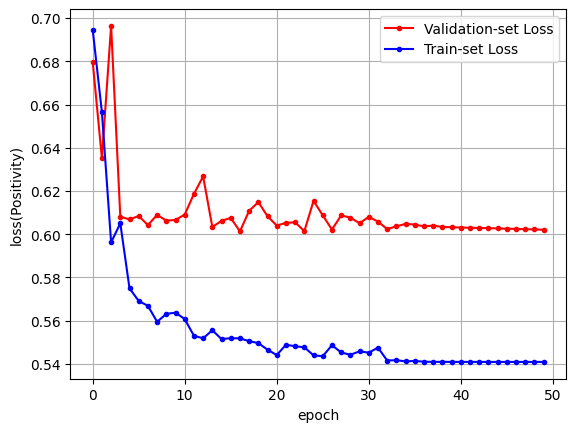

In [70]:

print("Building model(positivity)")
model_pos_rnn = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
    tf.keras.layers.Lambda(lambda x: tf.reshape(extract_first_element(x), (-1, 1))),
])

model_pos_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits= True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

history1 = model_pos_rnn.fit(train_dataset_pos, epochs=50,
                    validation_data=test_dataset_pos,
                    validation_steps=10)

#Plotting
y_vloss = history1.history['val_loss']
y_loss = history1.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss(Positivity)')
plt.show()


Building model(excitement)
Epoch 1/50


2023-06-22 20:52:17.557225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1613]
	 [[{{node Placeholder/_1}}]]
2023-06-22 20:52:19.922995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-22 20:52:22.640203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for plac

48/51 [===========================>..] - ETA: 0s - loss: 0.6713 - accuracy: 0.6979

2023-06-22 20:52:25.050739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [404]
	 [[{{node Placeholder/_1}}]]


51/51 [==============================] - 10s 64ms/step - loss: 0.6662 - accuracy: 0.7037 - val_loss: 0.6316 - val_accuracy: 0.7625
Epoch 2/50
51/51 [==============================] - 1s 18ms/step - loss: 0.6070 - accuracy: 0.7985 - val_loss: 0.5549 - val_accuracy: 0.8438
Epoch 3/50
51/51 [==============================] - 1s 18ms/step - loss: 0.5215 - accuracy: 0.9027 - val_loss: 0.5387 - val_accuracy: 0.8125
Epoch 4/50
51/51 [==============================] - 1s 18ms/step - loss: 0.5028 - accuracy: 0.9206 - val_loss: 0.5476 - val_accuracy: 0.8531
Epoch 5/50
51/51 [==============================] - 1s 19ms/step - loss: 0.5062 - accuracy: 0.9126 - val_loss: 0.5343 - val_accuracy: 0.8250
Epoch 6/50
51/51 [==============================] - 1s 18ms/step - loss: 0.4943 - accuracy: 0.9411 - val_loss: 0.5242 - val_accuracy: 0.8562
Epoch 7/50
51/51 [==============================] - 1s 19ms/step - loss: 0.4898 - accuracy: 0.9504 - val_loss: 0.5228 - val_accuracy: 0.8656
Epoch 8/50
51/51 [=====

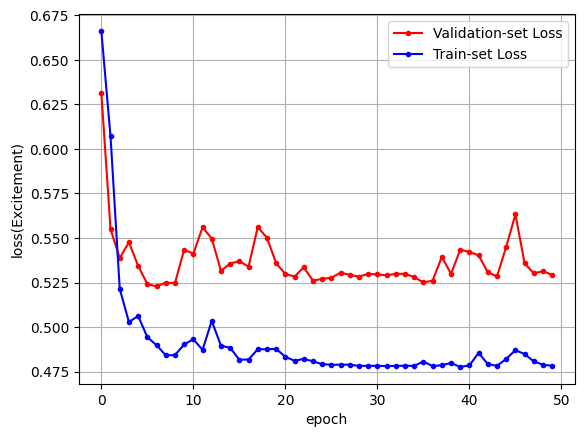

In [71]:



print("Building model(excitement)")
model_exc_rnn = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
    tf.keras.layers.Lambda(lambda x: tf.reshape(extract_first_element(x), (-1, 1))),
])

model_exc_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits= True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

history2 = model_exc_rnn.fit(train_dataset_exc, epochs=50,
                    validation_data=test_dataset_exc,
                    validation_steps=10)

#Plotting
y_vloss = history2.history['val_loss']
y_loss = history2.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss(Excitement)')
plt.show()


train_n:  1613 , test_n:  404
TEXT ENCODER


2023-06-22 20:54:09.716957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1613]
	 [[{{node Placeholder/_0}}]]
2023-06-22 20:54:09.717407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1613]
	 [[{{node Placeholder/_1}}]]


Building model
Epoch 1/100


2023-06-22 20:54:11.597306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1613]
	 [[{{node Placeholder/_0}}]]
2023-06-22 20:54:11.597744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1613]
	 [[{{node Placeholder/_1}}]]
2023-06-22 20:54:14.030057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis

50/51 [============================>.] - ETA: 0s - loss: 7570.6108 - accuracy: 0.0000e+00

2023-06-22 20:54:20.339068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [404]
	 [[{{node Placeholder/_1}}]]


51/51 [==============================] - 11s 73ms/step - loss: 7594.5718 - accuracy: 0.0000e+00 - val_loss: 7415.7373 - val_accuracy: 0.0000e+00
Epoch 2/100
51/51 [==============================] - 1s 28ms/step - loss: 5924.5171 - accuracy: 0.0000e+00 - val_loss: 5278.3936 - val_accuracy: 0.0000e+00
Epoch 3/100
51/51 [==============================] - 2s 30ms/step - loss: 3488.6003 - accuracy: 0.0000e+00 - val_loss: 3961.3320 - val_accuracy: 0.0000e+00
Epoch 4/100
51/51 [==============================] - 2s 30ms/step - loss: 2325.9504 - accuracy: 0.0000e+00 - val_loss: 3381.1997 - val_accuracy: 0.0000e+00
Epoch 5/100
51/51 [==============================] - 2s 30ms/step - loss: 1862.5430 - accuracy: 0.0000e+00 - val_loss: 3228.2893 - val_accuracy: 0.0000e+00
Epoch 6/100
51/51 [==============================] - 2s 30ms/step - loss: 1622.7609 - accuracy: 0.0000e+00 - val_loss: 3584.2935 - val_accuracy: 0.0000e+00
Epoch 7/100
51/51 [==============================] - 1s 29ms/step - loss: 1

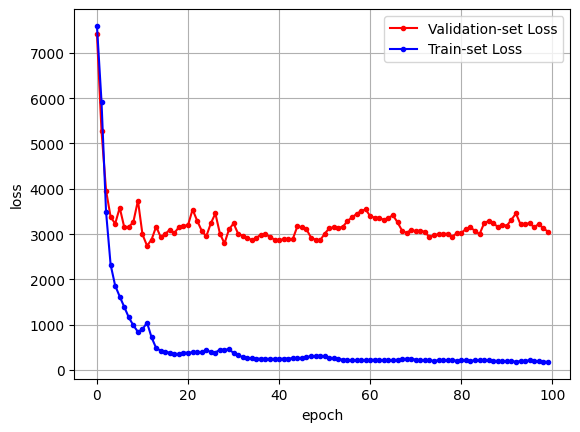

In [73]:

train_ratio = 0.8
data_file = '/mnt/nas2/seogyeong/23spring/arranged_emotion_text_angle_shuffled.csv'
df = pd.read_csv(data_file, encoding='UTF8', header=None, dtype={'a': str, 'b':float}).to_numpy()[1:]
sentences = df.T[0]

train_n = int(len(df) * train_ratio)
test_n = len(df) - train_n
print("train_n: ", train_n, ", test_n: ", test_n)

train_dataset = tf.data.Dataset.from_tensor_slices((df.T[0].T[:train_n], df.T[1].T[:train_n].astype(float)))
test_dataset = tf.data.Dataset.from_tensor_slices((df.T[0].T[train_n:], df.T[1].T[train_n:].astype(float)))

BUFFER_SIZE = 10
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

print("TEXT ENCODER")
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))


vocab = np.array(encoder.get_vocabulary())

print("Building model")

def round_below(x):
    a = tf.math.add(x, -0.5)
    return tf.round(a)


def custom_activation(x):
    a = round_below(tf.math.multiply(x, 1.0/360))
    x = tf.math.add_n([x, tf.math.multiply(a, -360.0)])
    return(x)

def custom_activation2(x):
    x = tf.keras.activations.tanh(x)
    x = tf.math.add(x, 1)
    x = tf.math.multiply(x, 180.0)
    return(x)

model_rnn = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation=custom_activation2)
])


def custom_loss_function(y_true, y_pred):
    difference = tf.math.abs(y_true - y_pred)
    condition = tf.greater(difference, 180.0)
    difference = tf.where(condition, tf.subtract(360.0, difference), difference)
    return tf.math.square(difference)


model_rnn.compile(loss=custom_loss_function,
              optimizer=tf.keras.optimizers.Adam(5e-4),
              metrics=['accuracy'])

history = model_rnn.fit(train_dataset, epochs=100,
                    validation_data=test_dataset,
                    validation_steps=10)

#Plotting
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


In [75]:
def novel_predict_RNN_binary(name, model_pos, model_exc, sentences, segment = None, step = None):
    avg_pos_neg = list()
    avg_exc_aro = list()
    total_pos_neg = list()
    total_exc_aro = list()
    
    if step is None:
        assert(segment is not None)
        divided_length = int(len(sentences)*(1/segment))
        last_length = len(sentences) - (segment-1)*divided_length
    else:
        divided_length = step
        segment = int((len(sentences)-1)/step)+1
        last_length = len(sentences) - (segment-1)*divided_length
    y_predict_pos = model_pos.predict(np.array(sentences))
    y_predict_exc = model_exc.predict(np.array(sentences))
    for i in range(segment):
        if i == segment - 1:
            pos_neg = []
            exc_aro = []
            for j in range(i*divided_length, len(sentences)):
                pos_neg.append(y_predict_pos[j] - 0.5)
                exc_aro.append(y_predict_exc[j] - 0.5)
                total_pos_neg.append(y_predict_pos[j] - 0.5)
                total_exc_aro.append(y_predict_exc[j] - 0.5)
            avg_pos_neg.append(sum(pos_neg)/len(pos_neg))
            avg_exc_aro.append(sum(exc_aro)/len(exc_aro))               
        else:
            pos_neg = []
            exc_aro = []
            for j in range(i*divided_length,(i+1)*divided_length):
                pos_neg.append(y_predict_pos[j] - 0.5)
                exc_aro.append(y_predict_exc[j] - 0.5)
                total_pos_neg.append(y_predict_pos[j] - 0.5)
                total_exc_aro.append(y_predict_exc[j] - 0.5)
            avg_pos_neg.append(sum(pos_neg)/len(pos_neg))
            avg_exc_aro.append(sum(exc_aro)/len(exc_aro))
    draw_binary(avg_pos_neg, avg_exc_aro, f"RNN binary")
    return total_pos_neg, total_exc_aro

In [76]:
def novel_predict_RNN_angle(name, model, sentences, segment = None, step = None):
    global result_str
    angle_av_list = []
    angle_tot_list = list()
    result_str += f"\n\n{name}\nangle\n"
    if step is None:
        assert(segment is not None)
        divided_length = int(len(sentences)*(1/segment))
        last_length = len(sentences) - (segment-1)*divided_length
    else:
        divided_length = step
        segment = int((len(sentences)-1)/step)+1
        last_length = len(sentences) - (segment-1)*divided_length
    y_predict = model.predict(np.array(sentences))
    for i in range(segment):
        if i == segment - 1:
            angle_av = 0
            for j in range(i*divided_length, len(sentences)):
                prediction = y_predict[j]
                if math.fabs(prediction - angle_av) >180:
                    if prediction < angle_av:
                        prediction += 360
                    else:
                        prediction -= 360
                current_total = angle_av * (j - i*divided_length)
                current_total += prediction
                angle_tot_list.append(prediction)
                angle_av = current_total / (j - i*divided_length + 1)
                if angle_av <0:
                    angle_av += 360
                if angle_av > 360:
                    angle_av -= 360
            angle_av_list.append(angle_av)
            result_str += f"{i}th segment: angle {angle_av}\n"
        else:
            angle_av = 0
            for j in range(i*divided_length,(i+1)*divided_length):
                prediction = y_predict[j]
                if math.fabs(prediction - angle_av) >180:
                    if prediction < angle_av:
                        prediction += 360
                    else:
                        prediction -= 360
                current_total = angle_av * (j - i*divided_length)
                current_total += prediction
                angle_tot_list.append(prediction)
                angle_av = current_total / (j - i*divided_length + 1)
                if angle_av <0:
                    angle_av += 360
                if angle_av > 360:
                    angle_av -= 360
            result_str += f"{i}th segment: angle {angle_av}\n"
            angle_av_list.append(angle_av)
    draw_angle( angle_av_list, f"RNN - angle")
    return angle_tot_list

In [77]:
def realtest_RNN(title):
    sentences = get_data(novel_path[title])
    print("Binary result")
    total_pos_neg, total_exc_aro = novel_predict_RNN_binary(title, model_pos_rnn, model_exc_rnn, sentences, step = 1)
    
    
    print("\n\nAngle result")
    total_ang = novel_predict_RNN_angle(title, model_rnn, sentences,  step = 1)
    
    return total_pos_neg, total_exc_aro, total_ang    

In [87]:
def novel_analysis(title):
    print("\n\n\nBERT\n\n")
    bert_pos_neg, bert_exc_aro, bert_ang = realtest_BERT(title)
    print("\n\n\nBoW\n\n")
    bow_pos_neg, bow_exc_aro, bow_ang = realtest_BoW(title)
    print("\n\n\nRNN\n\n")
    rnn_pos_neg, rnn_exc_aro, rnn_ang = realtest_RNN(title)
    print("-------Statistic---------")
    
    print("BERT binary - BERT angle")
    angle = calculate_diff((bert_pos_neg, bert_exc_aro), bert_ang)
    print(angle, "\n")
    
    print("BERT binary - BoW binary")
    angle = calculate_diff((bert_pos_neg, bert_exc_aro), (bow_pos_neg, bow_exc_aro), False, False)
    print(angle, "\n")
    
    print("BERT binary - BoW angle")
    angle = calculate_diff((bert_pos_neg, bert_exc_aro), bow_ang, False, True)
    print(angle, "\n")
    
    print("BERT binary - RNN binary")
    angle = calculate_diff((bert_pos_neg, bert_exc_aro), (rnn_pos_neg, rnn_exc_aro), False, False)
    print(angle, "\n")
    
    print("BERT binary - RNN angle")
    angle = calculate_diff((bert_pos_neg, bert_exc_aro), rnn_ang, False, True)
    print(angle, "\n")
    
    
    
    
    print("BERT angle - BoW binary")
    angle = calculate_diff(bert_ang, (bow_pos_neg, bow_exc_aro), True, False)
    print(angle, "\n")
    
    print("BERT angle - BoW angle")
    angle = calculate_diff(bert_ang, bow_ang, True, True)
    print(angle, "\n")
    
    print("BERT angle - RNN binary")
    angle = calculate_diff(bert_ang, (rnn_pos_neg, rnn_exc_aro), True, False)
    print(angle, "\n")
    
    print("BERT angle - RNN angle")
    angle = calculate_diff(bert_ang, rnn_ang, True, True)
    print(angle, "\n")
    
    
    
    
    print("BoW binary - BoW angle")
    angle = calculate_diff((bow_pos_neg, bow_exc_aro), bow_ang, False, True)
    print(angle, "\n")
    
    print("BoW binary - RNN binary")
    angle = calculate_diff((bow_pos_neg, bow_exc_aro), (rnn_pos_neg, rnn_exc_aro), False, False)
    print(angle, "\n")
    
    print("BoW binary - RNN angle")
    angle = calculate_diff((bow_pos_neg, bow_exc_aro), rnn_ang, False, True)
    print(angle, "\n")
    
    
    print("BoW angle - RNN binary")
    angle = calculate_diff(bow_ang, (rnn_pos_neg, rnn_exc_aro), True, False)
    print(angle, "\n")
    
    print("BoW angle - RNN angle")
    angle = calculate_diff(bow_ang, rnn_ang, True, True)
    print(angle, "\n")
    
    
    print("RNN binary - RNN angle")
    angle = calculate_diff((rnn_pos_neg, rnn_exc_aro), rnn_ang, False, True)
    print(angle, "\n")
    




BERT


Binary result


/root/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


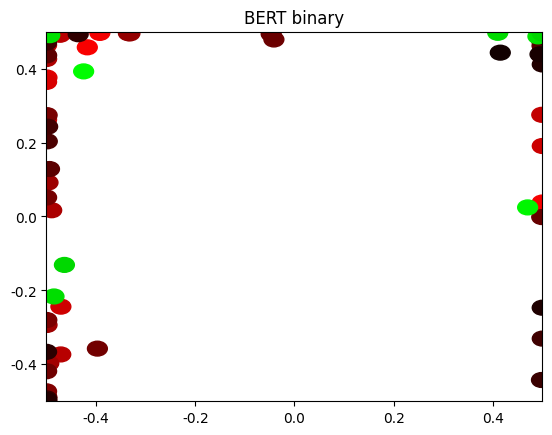



Angle result


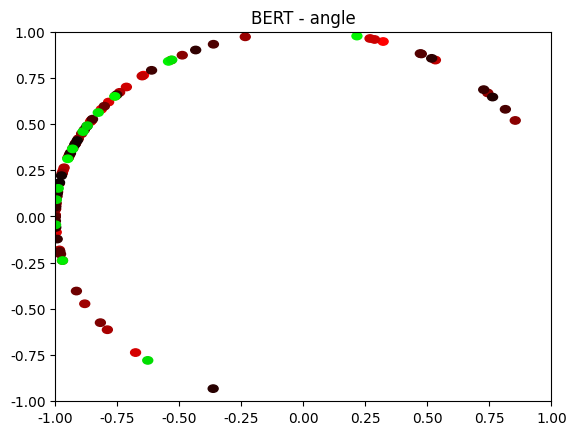




BoW


Binary result
95


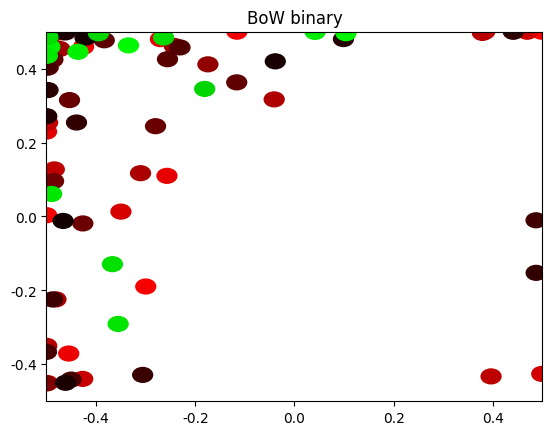



Angle result


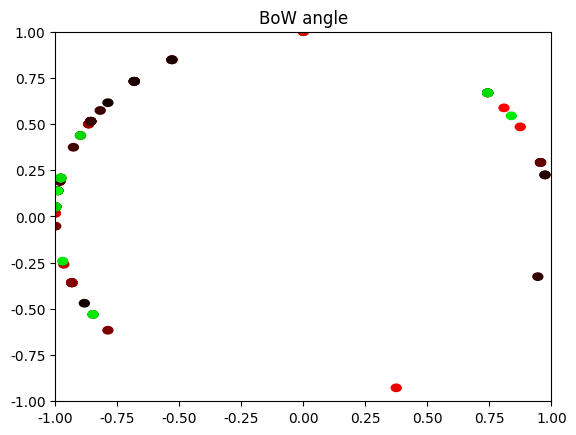




RNN


Binary result
3/3 [==============================] - 0s 21ms/step


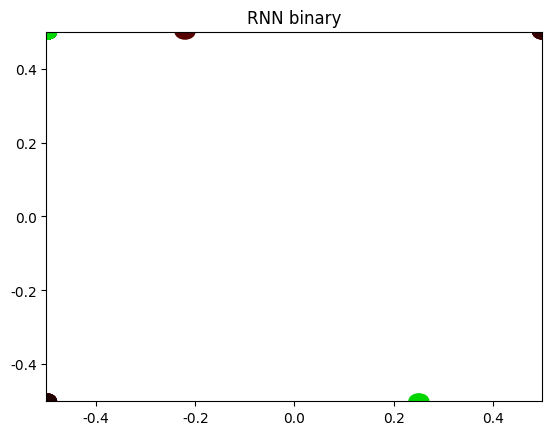



Angle result
3/3 [==============================] - 0s 39ms/step


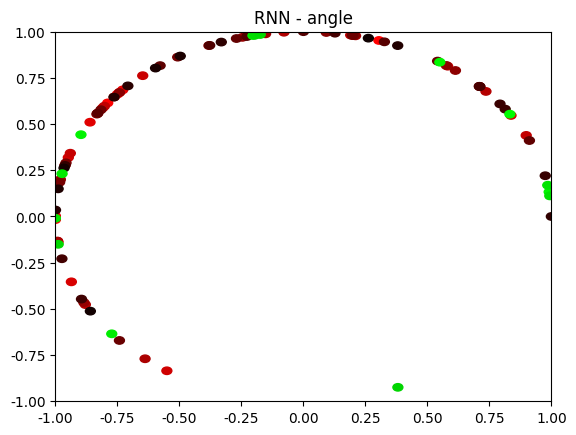

-------Statistic---------
BERT binary - BERT angle
56.234565172697366 

BERT binary - BoW binary
73.01915522513444 

BERT binary - BoW angle
80.7996050685756 

BERT binary - RNN binary
70.84482421875 

BERT binary - RNN angle
70.4986173930921 

BERT angle - BoW binary
49.90260074013158 

BERT angle - BoW angle
53.316252055921055 

BERT angle - RNN binary
45.626449424342105 

BERT angle - RNN angle
58.96383120888158 

BoW binary - BoW angle
52.164086669890914 

BoW binary - RNN binary
38.11069592927632 

BoW binary - RNN angle
61.426115337171055 

BoW angle - RNN binary
53.93117804276316 

BoW angle - RNN angle
67.25375719572368 

RNN binary - RNN angle
49.552749794407895 



In [88]:
novel_analysis("광염소나타")




BERT


Binary result


/root/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


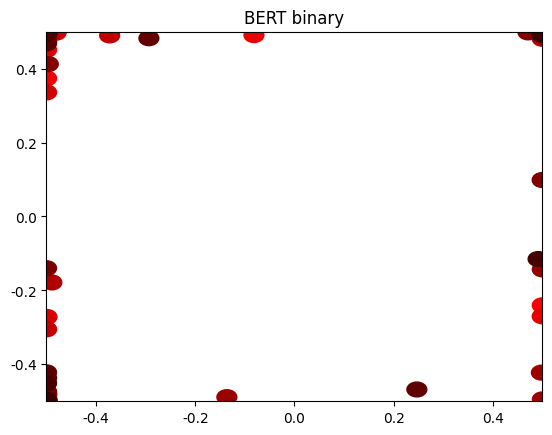



Angle result


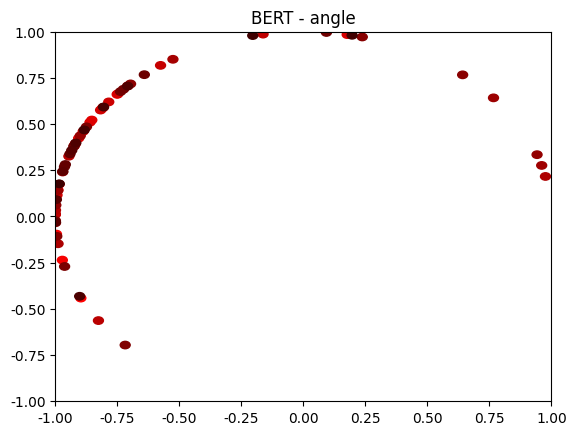




BoW


Binary result
66


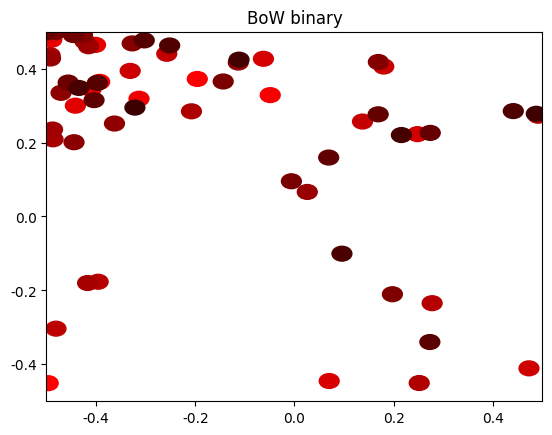



Angle result


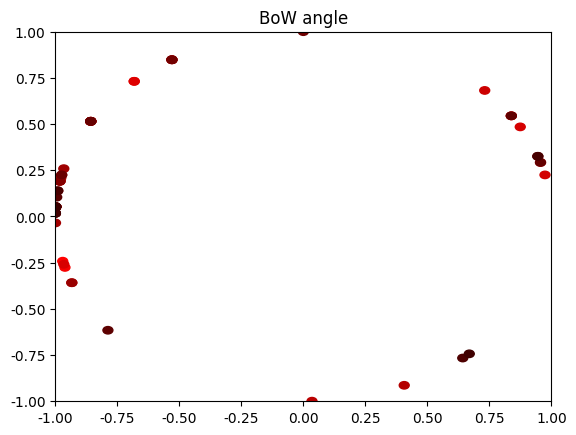




RNN


Binary result
3/3 [==============================] - 0s 11ms/step


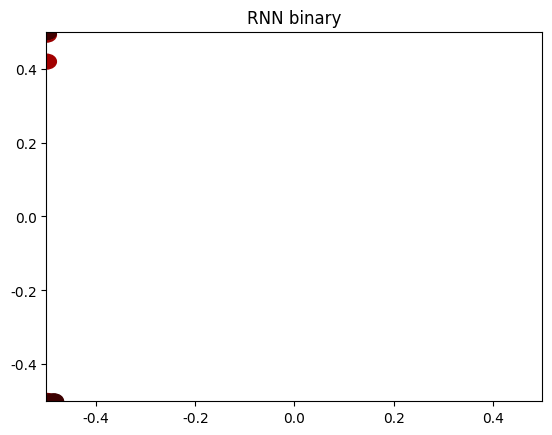



Angle result
3/3 [==============================] - 0s 14ms/step


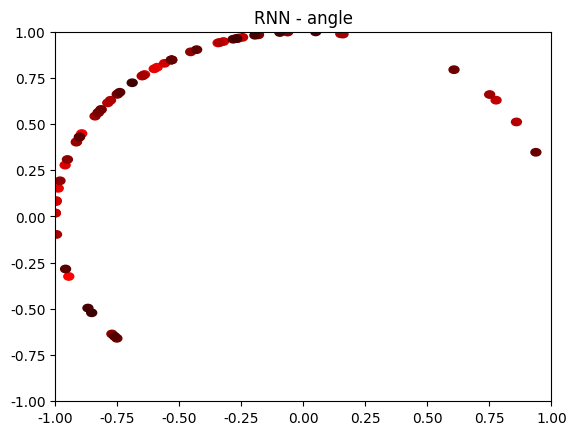

-------Statistic---------
BERT binary - BERT angle
47.62545868844697 

BERT binary - BoW binary
84.21909659719257 

BERT binary - BoW angle
71.0019076350254 

BERT binary - RNN binary
68.57131865530303 

BERT binary - RNN angle
72.55547910748106 

BERT angle - BoW binary
55.643569483901516 

BERT angle - BoW angle
55.02068906841856 

BERT angle - RNN binary
42.16557173295455 

BERT angle - RNN angle
51.09390906131629 

BoW binary - BoW angle
47.56599586397863 

BoW binary - RNN binary
48.38550544507576 

BoW binary - RNN angle
51.9974365234375 

BoW angle - RNN binary
57.63991477272727 

BoW angle - RNN angle
60.27639678030303 

RNN binary - RNN angle
35.16473203716856 



In [89]:
novel_analysis("매밀꽃필무렵")




BERT


Binary result


/root/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


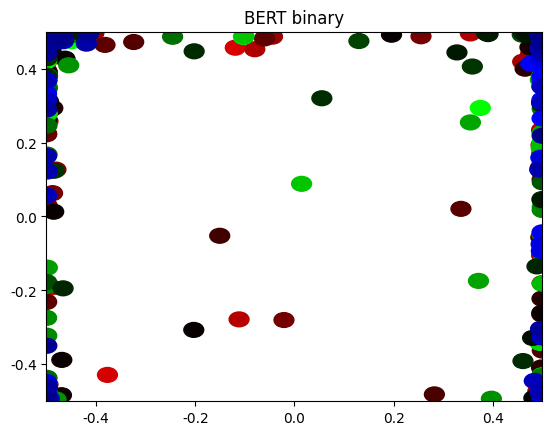



Angle result


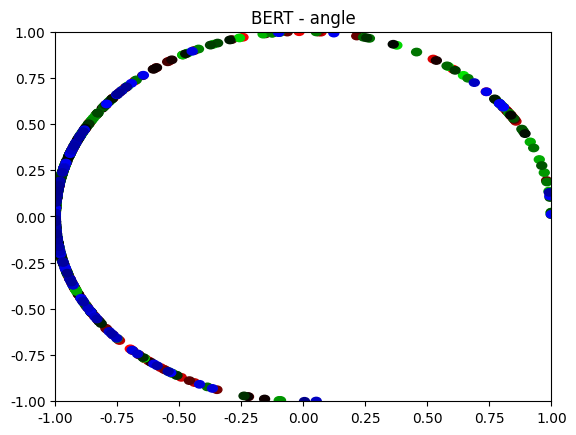




BoW


Binary result
619


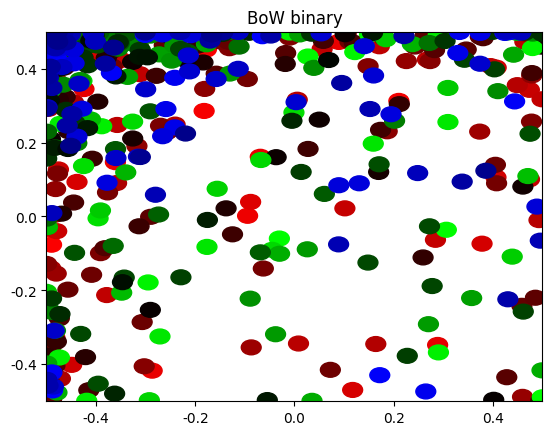



Angle result


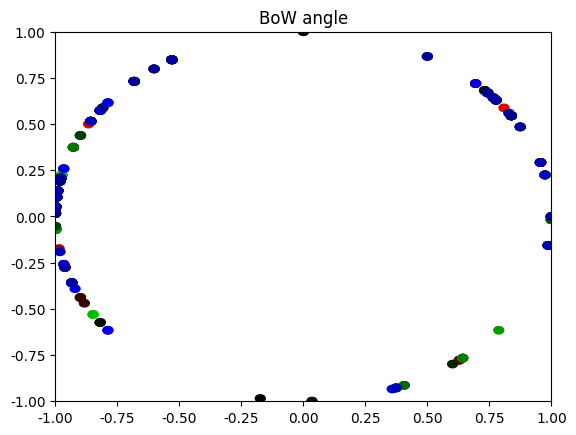




RNN


Binary result
20/20 [==============================] - 0s 17ms/step


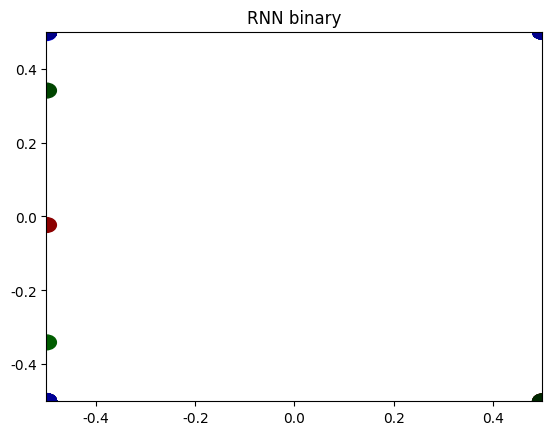



Angle result
20/20 [==============================] - 1s 29ms/step


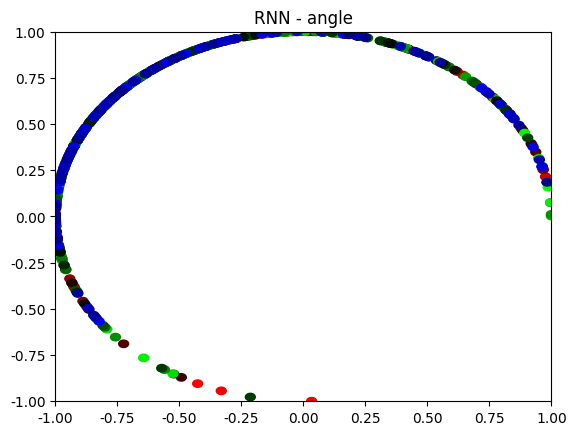

-------Statistic---------
BERT binary - BERT angle
78.37425535137318 

BERT binary - BoW binary
79.37635271662859 

BERT binary - BoW angle
90.35157319308384 

BERT binary - RNN binary
86.02237101171244 

BERT binary - RNN angle
73.41921824515347 

BERT angle - BoW binary
58.94948379442649 

BERT angle - BoW angle
60.558518023021 

BERT angle - RNN binary
52.46203869648627 

BERT angle - RNN angle
64.13530517972536 

BoW binary - BoW angle
52.08353160177757 

BoW binary - RNN binary
46.20469949010501 

BoW binary - RNN angle
55.41803185581583 

BoW angle - RNN binary
58.9834725868336 

BoW angle - RNN angle
66.0436061187399 

RNN binary - RNN angle
43.97087982128433 



In [90]:
novel_analysis("창세기40장")




BERT


Binary result


/root/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


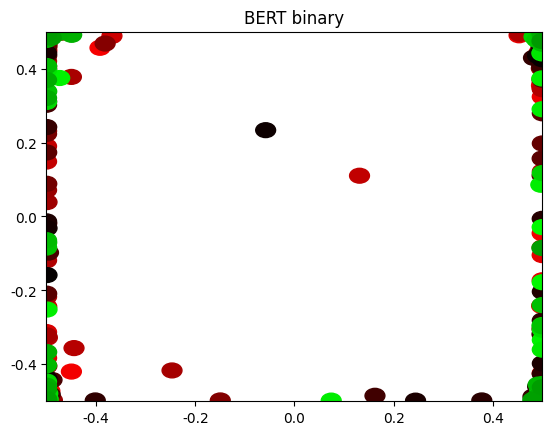



Angle result


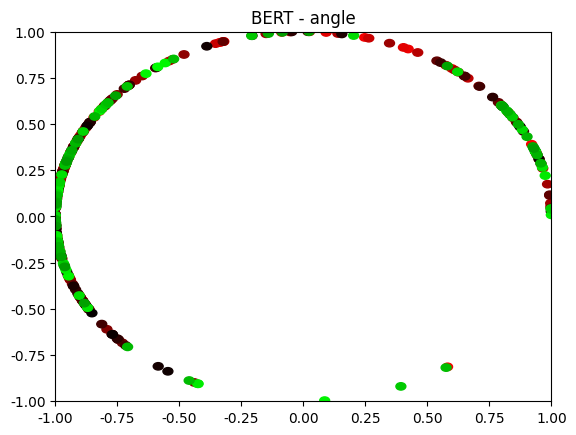




BoW


Binary result
352


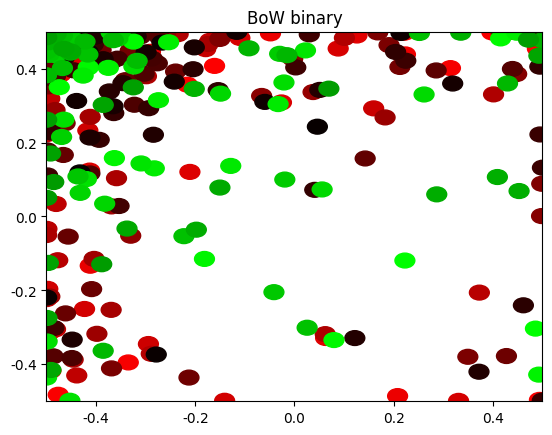



Angle result


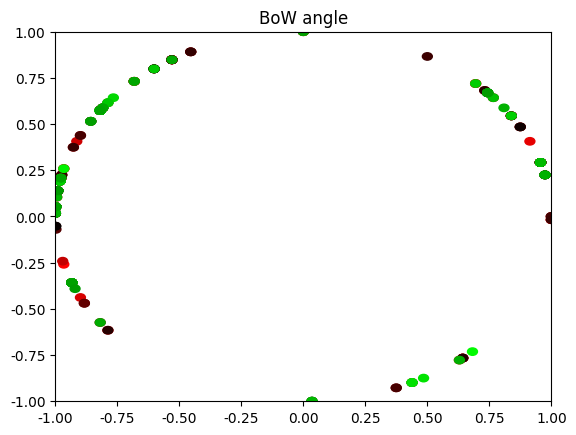




RNN


Binary result
11/11 [==============================] - 0s 17ms/step


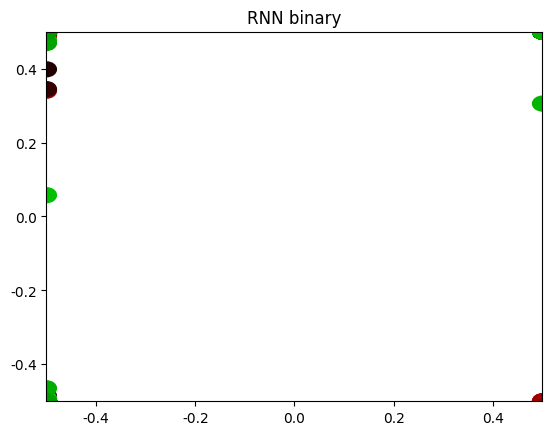



Angle result
11/11 [==============================] - 0s 26ms/step


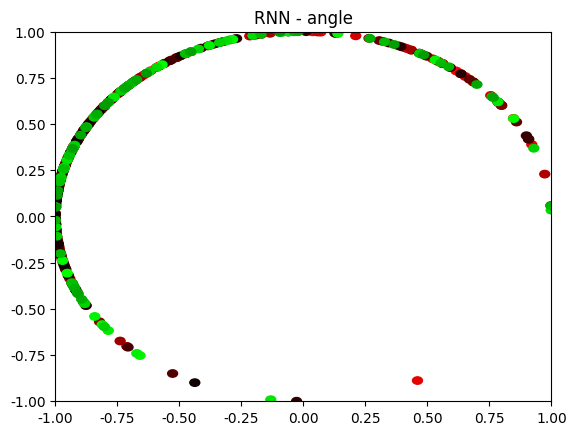

-------Statistic---------
BERT binary - BERT angle
51.73165061257102 

BERT binary - BoW binary
81.72476442999675 

BERT binary - BoW angle
81.20695040474419 

BERT binary - RNN binary
85.35477516867898 

BERT binary - RNN angle
73.66682572798295 

BERT angle - BoW binary
59.48846435546875 

BERT angle - BoW angle
62.78117231889205 

BERT angle - RNN binary
57.2346024946733 

BERT angle - RNN angle
61.7743086381392 

BoW binary - BoW angle
50.21704613150998 

BoW binary - RNN binary
45.373779296875 

BoW binary - RNN angle
54.15791459517045 

BoW angle - RNN binary
62.6573486328125 

BoW angle - RNN angle
63.63044322620738 

RNN binary - RNN angle
48.28243186257102 



In [91]:
novel_analysis("어린왕자")




BERT


Binary result


/root/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


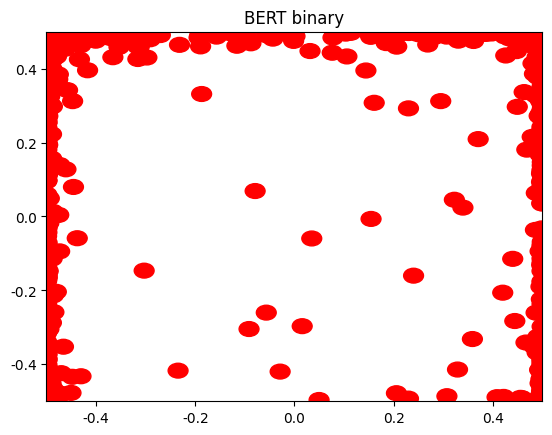



Angle result


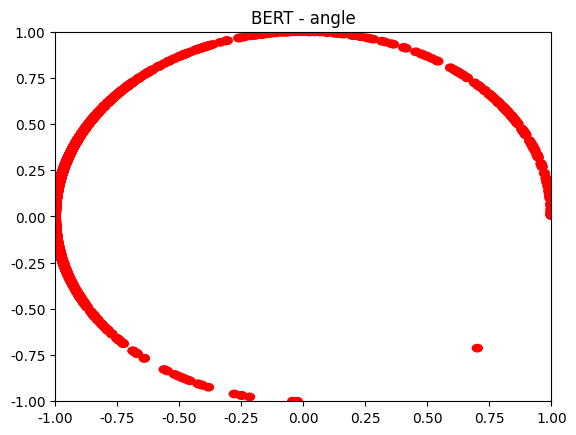




BoW


Binary result
1298


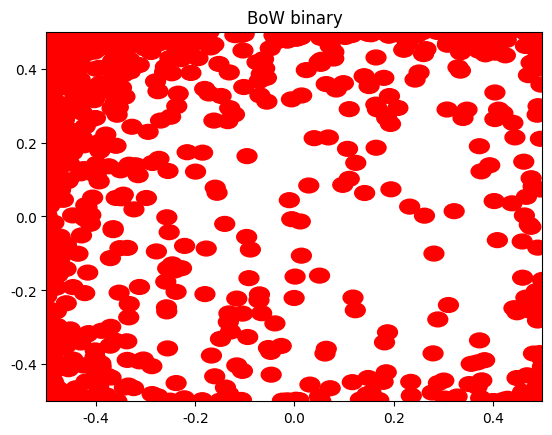



Angle result


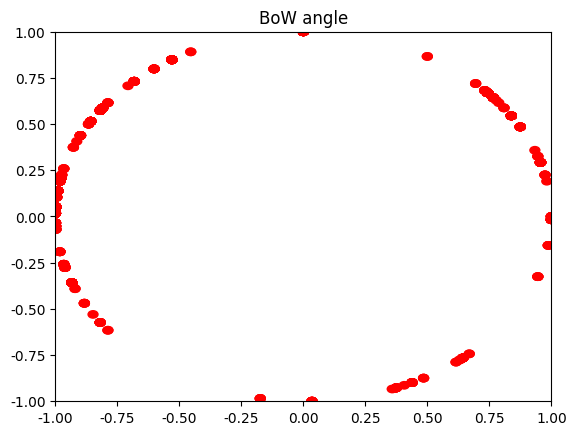




RNN


Binary result
41/41 [==============================] - 1s 28ms/step


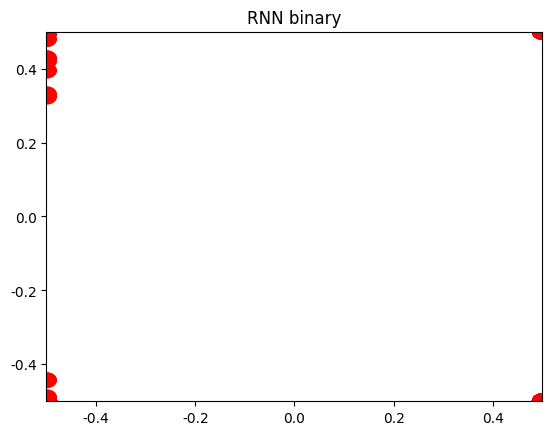



Angle result
41/41 [==============================] - 2s 54ms/step


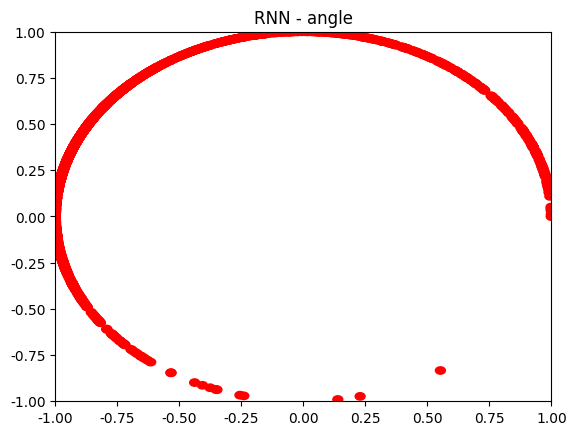

-------Statistic---------
BERT binary - BERT angle
47.82030648112481 

BERT binary - BoW binary
66.38438338276283 

BERT binary - BoW angle
72.88903714073902 

BERT binary - RNN binary
64.16068591101696 

BERT binary - RNN angle
65.41999109206472 

BERT angle - BoW binary
48.69725659668721 

BERT angle - BoW angle
56.363822948767336 

BERT angle - RNN binary
47.68736156587057 

BERT angle - RNN angle
57.498007752311246 

BoW binary - BoW angle
52.799737288153224 

BoW binary - RNN binary
49.489509100539294 

BoW binary - RNN angle
58.21981534090909 

BoW angle - RNN binary
57.00221494607088 

BoW angle - RNN angle
64.27420791602465 

RNN binary - RNN angle
47.38686621244222 



In [92]:
# novel_analysis("허클베리핀의모험")

In [93]:
f = open(result_dir, 'w')
f.write(result_str)
f.close()